# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [3]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0, )
]

In [4]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

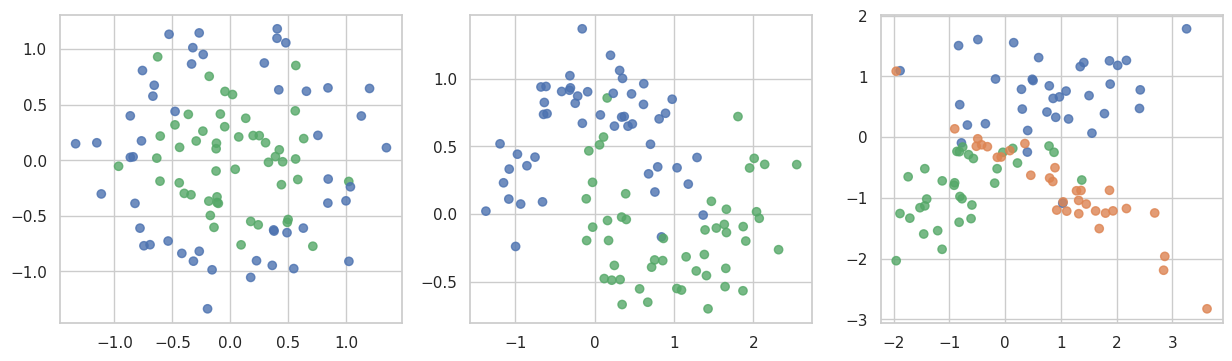

In [5]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [6]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

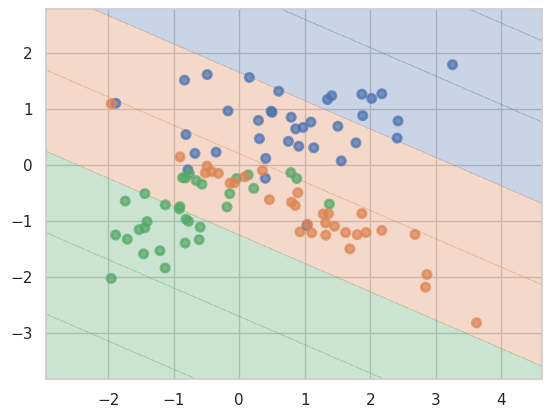

In [7]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

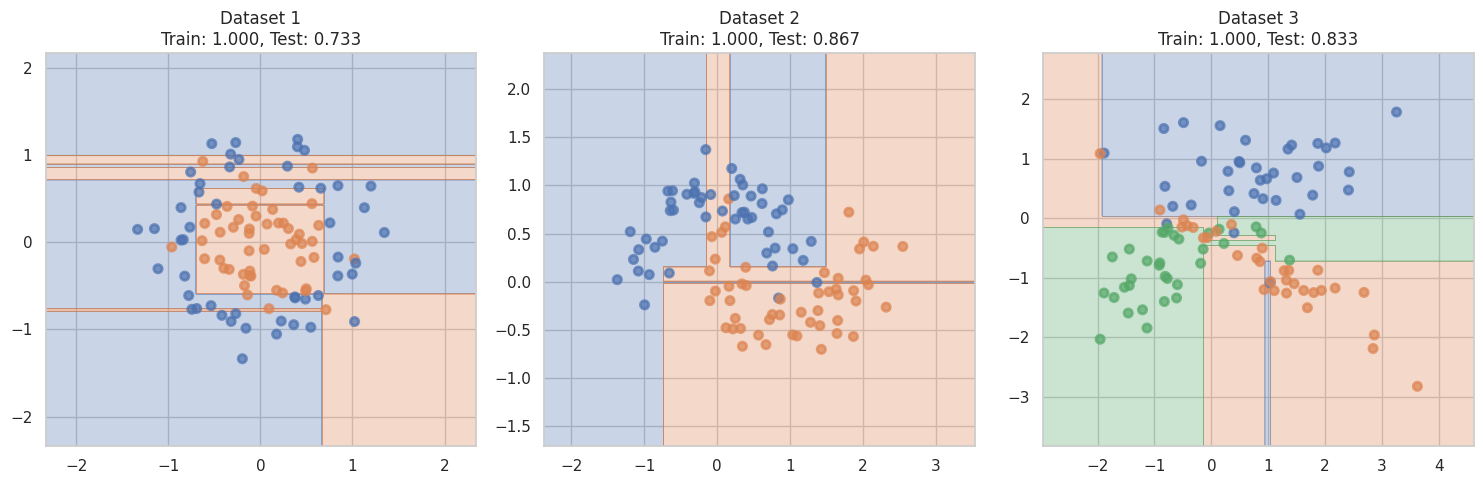

In [9]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

plt.figure(figsize=(15, 5))

for i, (X, y) in enumerate(datasets):
    # Разбиваем данные на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Обучаем решающее дерево с параметрами по умолчанию
    tree = DecisionTreeClassifier(random_state=42)
    tree.fit(X_train, y_train)

    # Считаем accuracy
    train_accuracy = tree.score(X_train, y_train)
    test_accuracy = tree.score(X_test, y_test)

    # Визуализация разделяющей поверхности
    plt.subplot(1, 3, i + 1)
    plot_surface(tree, X, y)
    plt.title(f'Dataset {i+1}\nTrain: {train_accuracy:.3f}, Test: {test_accuracy:.3f}')

plt.tight_layout()
plt.show()

__Ответ:__
произошло переобучение, можно заметить это по визуализации и разнице между accuracy test и train выборок



__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

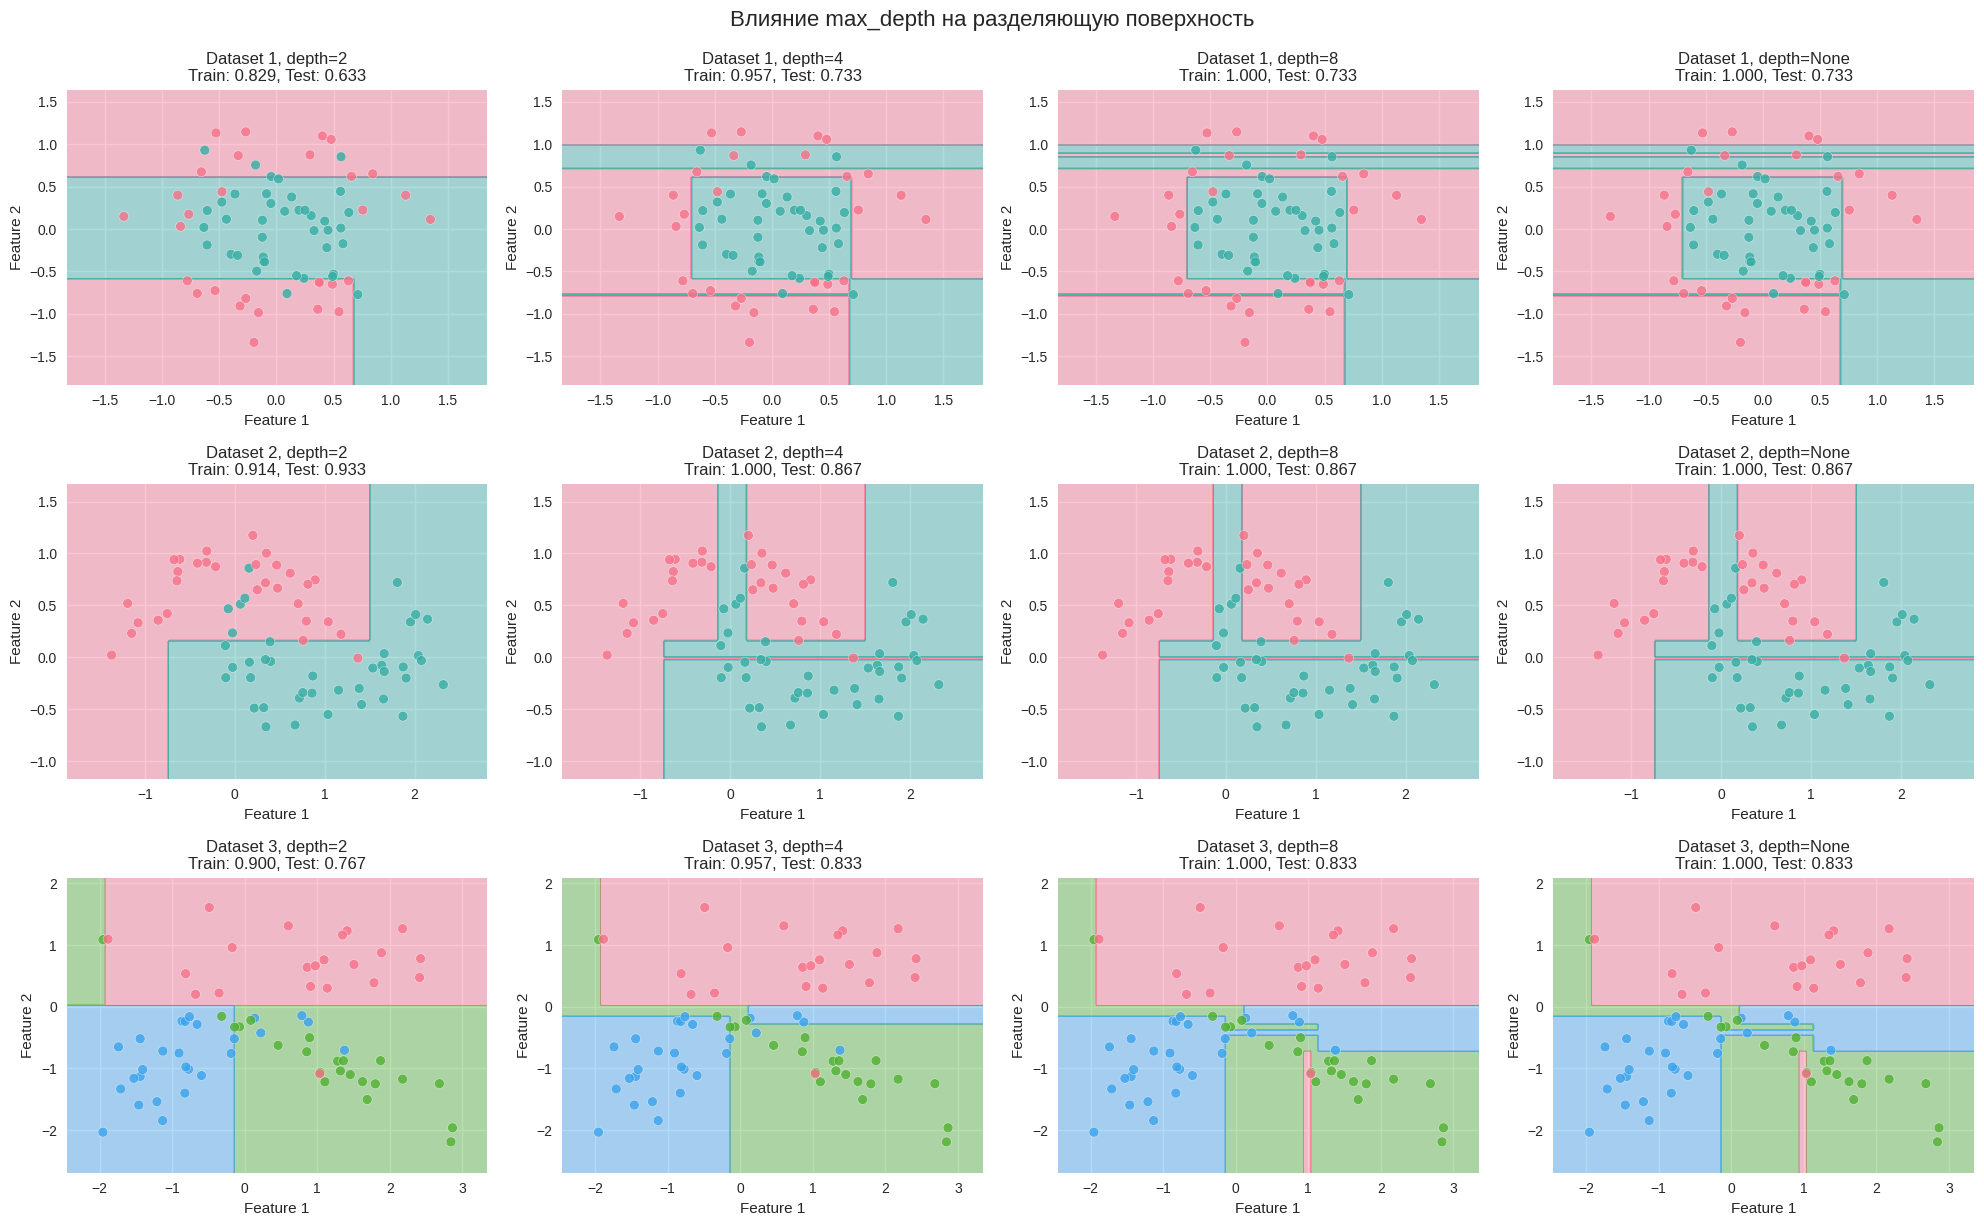

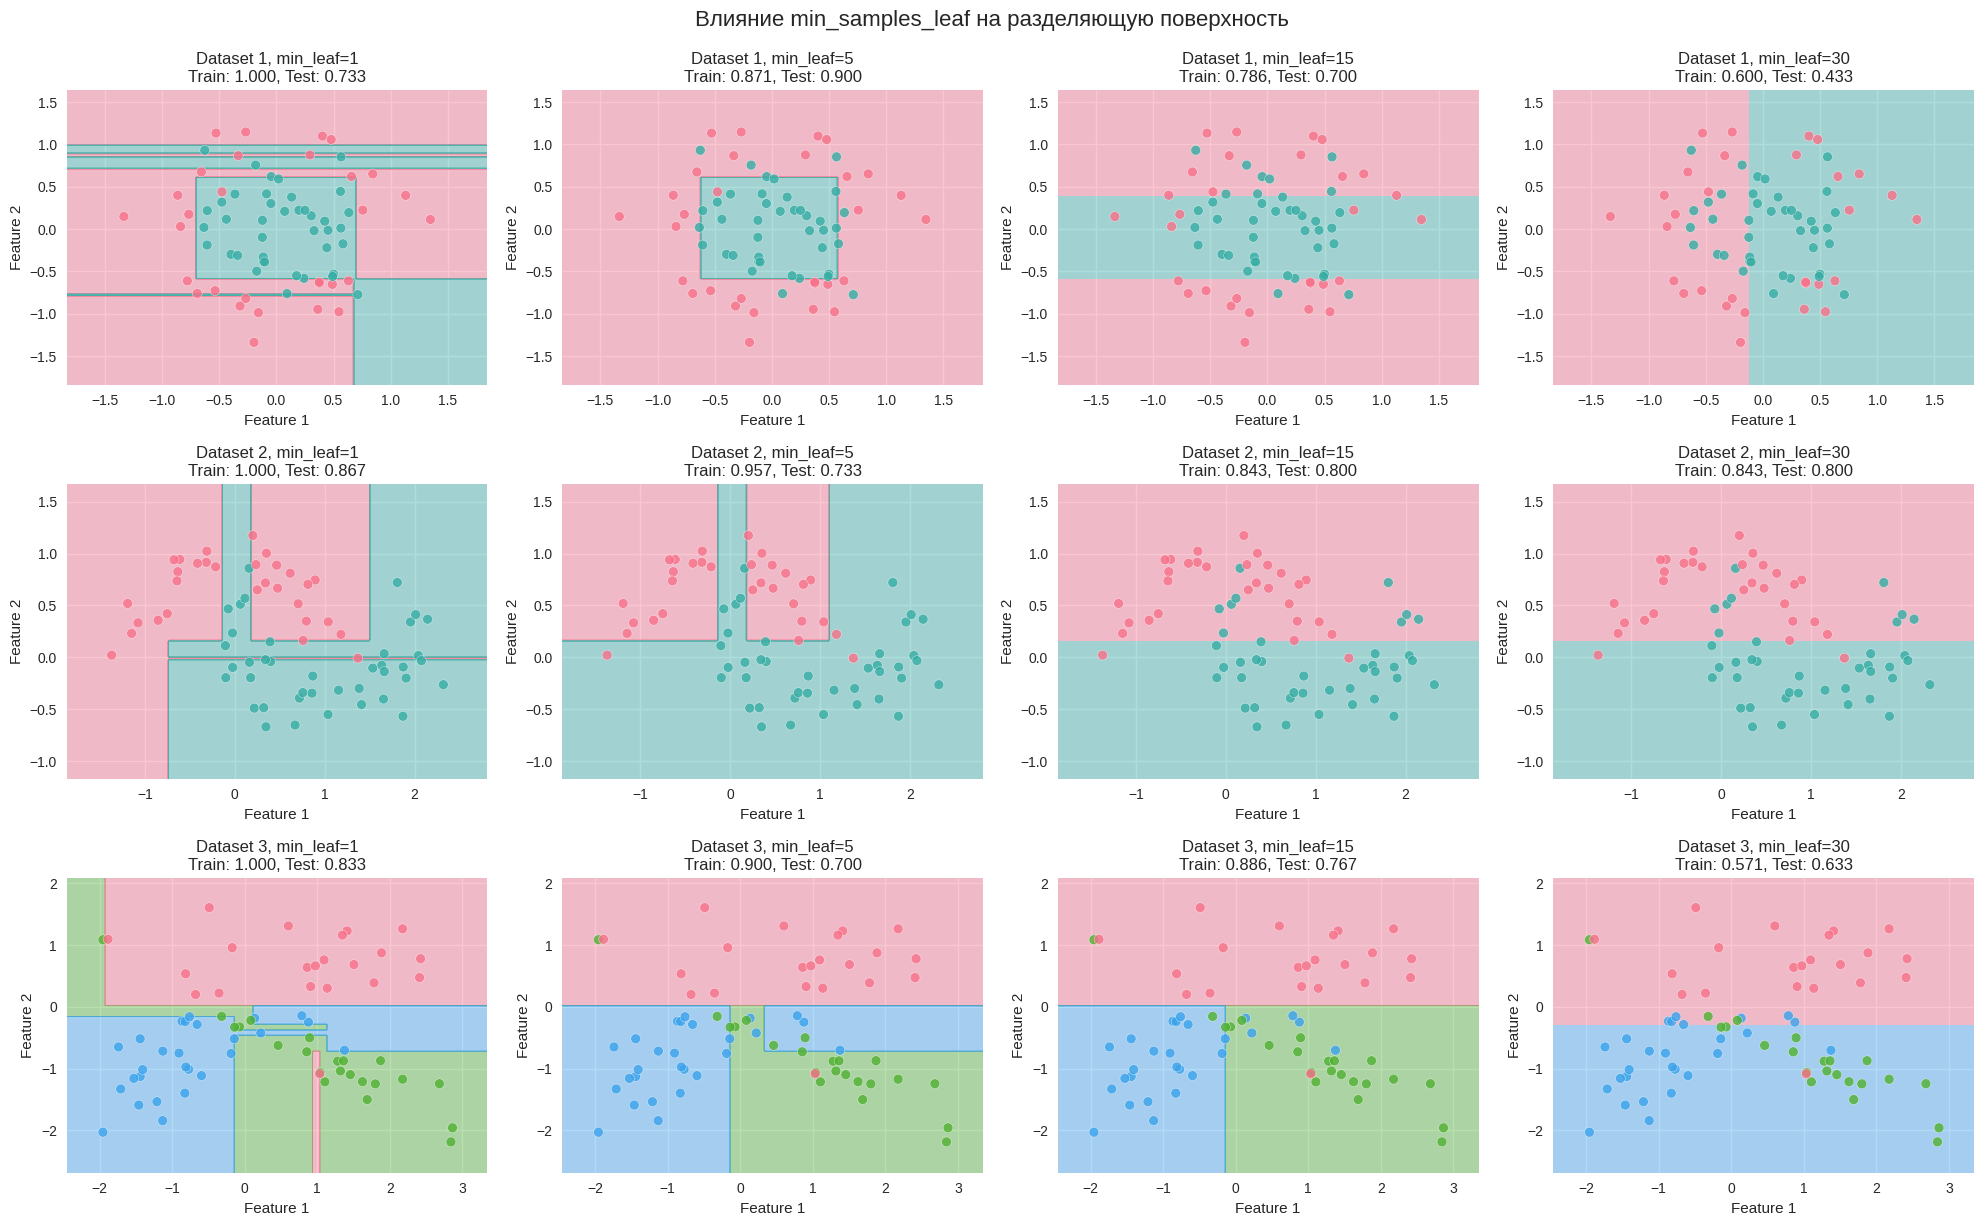

<Figure size 1500x1000 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap
import seaborn as sns

plt.style.use('seaborn-v0_8')

def plot_decision_surface(clf, X, y):
    step = 0.02
    n_classes = len(np.unique(y))
    palette = sns.color_palette("husl", n_colors=n_classes)
    cmap = ListedColormap(palette)

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                         np.arange(y_min, y_max, step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.4)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap,
                         edgecolors='white', s=50, alpha=0.8)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


depth_params = [2, 4, 8, None]
fig, axes = plt.subplots(len(datasets), len(depth_params), figsize=(20, 12))

for i, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    for j, depth in enumerate(depth_params):

        clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
        clf.fit(X_train, y_train)


        train_acc = clf.score(X_train, y_train)
        test_acc = clf.score(X_test, y_test)

        ax = axes[i, j]
        plt.sca(ax)
        plot_decision_surface(clf, X_train, y_train)

        depth_str = "None" if depth is None else str(depth)
        ax.set_title(f'Dataset {i+1}, depth={depth_str}\nTrain: {train_acc:.3f}, Test: {test_acc:.3f}')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')

plt.tight_layout()
plt.suptitle('Влияние max_depth на разделяющую поверхность', fontsize=16, y=1.02)
plt.show()


leaf_params = [1, 5, 15, 30]
fig, axes = plt.subplots(len(datasets), len(leaf_params), figsize=(20, 12))

for i, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    for j, leaf_size in enumerate(leaf_params):

        clf = DecisionTreeClassifier(min_samples_leaf=leaf_size, random_state=42)
        clf.fit(X_train, y_train)

        train_acc = clf.score(X_train, y_train)
        test_acc = clf.score(X_test, y_test)

        ax = axes[i, j]
        plt.sca(ax)
        plot_decision_surface(clf, X_train, y_train)

        ax.set_title(f'Dataset {i+1}, min_leaf={leaf_size}\nTrain: {train_acc:.3f}, Test: {test_acc:.3f}')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')

plt.tight_layout()
plt.suptitle('Влияние min_samples_leaf на разделяющую поверхность', fontsize=16, y=1.02)
plt.show()


plt.figure(figsize=(15, 10))

depth_range = range(1, 16)
train_scores_depth = [[] for _ in range(3)]
test_scores_depth = [[] for _ in range(3)]

for i, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    for depth in depth_range:
        clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
        clf.fit(X_train, y_train)

        train_scores_depth[i].append(clf.score(X_train, y_train))
        test_scores_depth[i].append(clf.score(X_test, y_test))




__Ответ:__
Чем больше max_depth, тем больше происходит усложнение поверхностей
Чем меньше min_samples_leaf, тем модель больше переобучается, подстраиваясь под train данные
От структуры датасета зависит сложность подбора параметров дерева, соотв чем она датасет по структуре сложнее, тем сложнее подбор параметров

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

In [23]:
def find_best_split(feature_vector, target_vector):
    """
    Под критерием Джини здесь подразумевается следующая функция:
    $$Q(R) = -\frac {|R_l|}{|R|}H(R_l) -\frac {|R_r|}{|R|}H(R_r)$$,
    $R$ — множество объектов, $R_l$ и $R_r$ — объекты, попавшие в левое и правое поддерево,
     $H(R) = 1-p_1^2-p_0^2$, $p_1$, $p_0$ — доля объектов класса 1 и 0 соответственно.
    """
    if len(np.unique(feature_vector)) == 1:
        return np.array([]), np.array([]), None, np.inf

    sorted_indices = np.argsort(feature_vector)
    feature_sorted = feature_vector[sorted_indices]
    target_sorted = target_vector[sorted_indices]


    unique_features = np.unique(feature_sorted)


    thresholds = (unique_features[:-1] + unique_features[1:]) / 2.0


    ginis = []
    valid_thresholds = []


    n_total = len(target_vector)

    for threshold in thresholds:

        left_mask = feature_sorted < threshold
        right_mask = ~left_mask

        n_left = np.sum(left_mask)
        n_right = n_total - n_left


        if n_left == 0 or n_right == 0:
            continue


        left_targets = target_sorted[left_mask]
        if len(left_targets) == 0:
            continue

        left_counts = np.bincount(left_targets, minlength=2)
        p_left_0 = left_counts[0] / n_left
        p_left_1 = left_counts[1] / n_left

        H_left = 1 - p_left_0**2 - p_left_1**2

        right_targets = target_sorted[right_mask]
        if len(right_targets) == 0:
            continue

        right_counts = np.bincount(right_targets, minlength=2)
        p_right_0 = right_counts[0] / n_right
        p_right_1 = right_counts[1] / n_right

        H_right = 1 - p_right_0**2 - p_right_1**2


        gini = -(n_left / n_total) * H_left - (n_right / n_total) * H_right

        ginis.append(gini)
        valid_thresholds.append(threshold)

    if not ginis:
        return np.array([]), np.array([]), None, np.inf

    ginis = np.array(ginis)
    valid_thresholds = np.array(valid_thresholds)

    best_idx = np.argmin(ginis)
    min_gini = ginis[best_idx]
    best_indices = np.where(ginis == min_gini)[0]
    best_idx = best_indices[0]

    threshold_best = valid_thresholds[best_idx]
    gini_best = ginis[best_idx]

    return valid_thresholds, ginis, threshold_best, gini_best

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

Информация о датасете:
Размерность: (258, 6)
Признаки: ['STG', 'SCG', 'STR', 'LPR', 'PEG']
Баланс классов: (array([0, 1]), array([107, 151]))


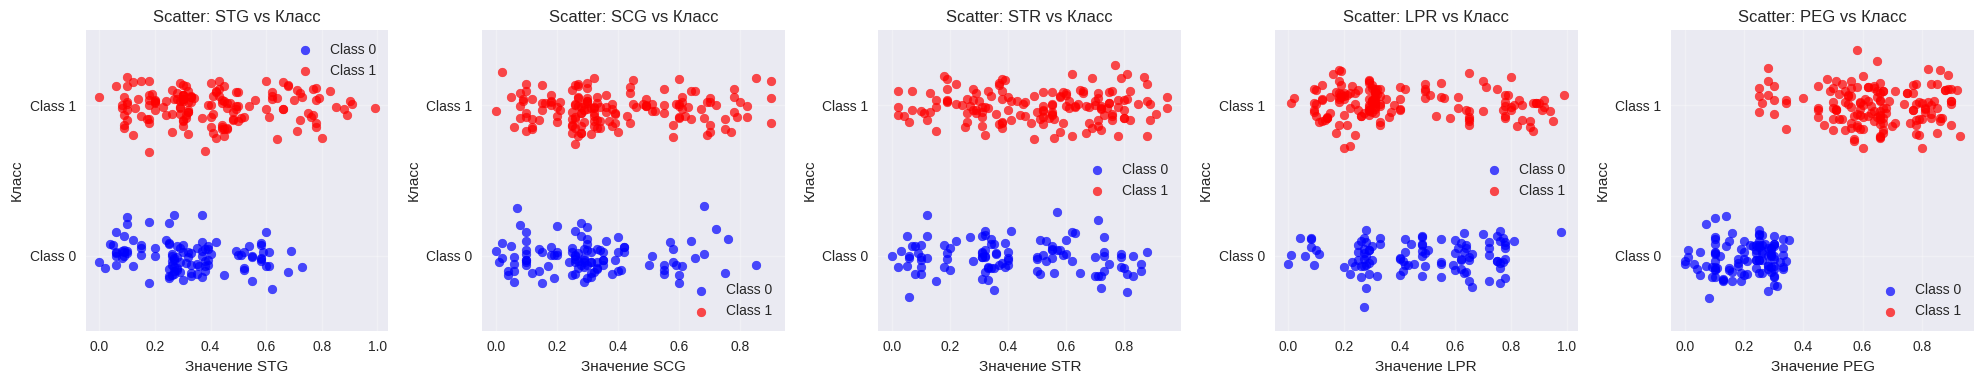

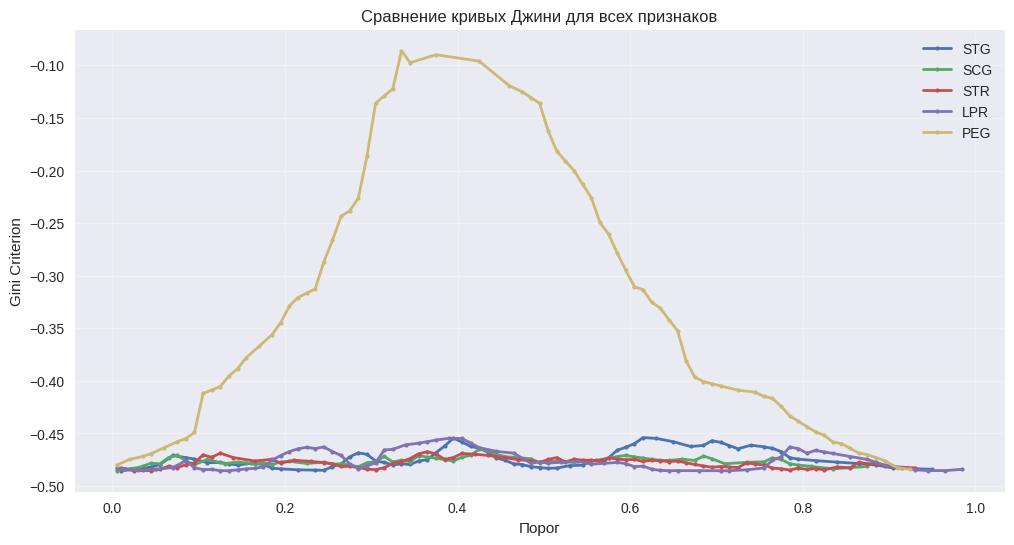

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

students = pd.read_csv('students.csv')
X = students.iloc[:, :-1].values
y = students.iloc[:, -1].values

feature_names = students.columns[:-1].tolist()

print("Информация о датасете:")
print(f"Размерность: {students.shape}")
print(f"Признаки: {feature_names}")
print(f"Баланс классов: {np.unique(y, return_counts=True)}")

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, feature_name in enumerate(feature_names):
    ax = axes[i]
    feature_values = students[feature_name].values


    class_0 = feature_values[y == 0]
    class_1 = feature_values[y == 1]


    y_jitter_0 = np.random.normal(-0.1, 0.02, len(class_0))
    y_jitter_1 = np.random.normal(0.1, 0.02, len(class_1))

    ax.scatter(class_0, y_jitter_0, alpha=0.7, label='Class 0', s=40, color='blue')
    ax.scatter(class_1, y_jitter_1, alpha=0.7, label='Class 1', s=40, color='red')

    ax.set_xlabel(f'Значение {feature_name}')
    ax.set_ylabel('Класс')
    ax.set_title(f'Scatter: {feature_name} vs Класс')
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax.set_yticks([-0.1, 0.1])
    ax.set_yticklabels(['Class 0', 'Class 1'])
    ax.set_ylim(-0.2, 0.2)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

for i, feature_name in enumerate(feature_names):
    feature_vector = students[feature_name].values
    thresholds, ginis, _, _ = find_best_split(feature_vector, y)

    if len(thresholds) > 0:
        plt.plot(thresholds, ginis, label=feature_name, linewidth=2, marker='o', markersize=3)

plt.xlabel('Порог')
plt.ylabel('Gini Criterion')
plt.title('Сравнение кривых Джини для всех признаков')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


**Ответ:**

*   Выбираем признак PEG для деления выборки, это согласуется с визуальной оценкой scatter графиков

*  Хорошие признаки имеют кривую с ярко выраженной вершиной, в отличие от плоских кривых, по котормым деление практически невозможно


__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [40]:

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from hw2code import DecisionTree

mushrooms = pd.read_csv('agaricus-lepiota.data', header=None)


column_names = [
    'class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
    'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
    'stalk-surface-below-ring', 'stalk-color-above-ring',
    'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
    'ring-type', 'spore-print-color', 'population', 'habitat'
]

mushrooms.columns = column_names

print("Информация о реальном датасете mushrooms:")
print(f"Размерность: {mushrooms.shape}")
print(f"Целевая переменная:\n{mushrooms['class'].value_counts()}")


label_encoders = {}
mushrooms_encoded = mushrooms.copy()

for column in mushrooms.columns:
    le = LabelEncoder()
    mushrooms_encoded[column] = le.fit_transform(mushrooms[column])
    label_encoders[column] = le
print(f"\nДанные после кодирования:")
print(mushrooms_encoded.head())

X = mushrooms_encoded.drop('class', axis=1).values
y = mushrooms_encoded['class'].values

print(f"\nФорма данных:")
print(f"X: {X.shape}, y: {y.shape}")


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)

print(f"\nРазделение данных:")
print(f"Обучающая выборка: {X_train.shape[0]} samples")
print(f"Тестовая выборка: {X_test.shape[0]} samples")
print(f"Распределение классов в train: {np.unique(y_train, return_counts=True)}")
print(f"Распределение классов в test: {np.unique(y_test, return_counts=True)}")


feature_types = ['categorical'] * X.shape[1]

print(f"\nОбучаем решающее дерево...")
tree = DecisionTree(feature_types=feature_types, max_depth=5, min_samples_leaf=10)
tree.fit(X_train, y_train)


y_pred = tree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nРезультаты:")
print(f"Accuracy на тестовой выборке: {accuracy:.4f}")
print(f"Accuracy в процентах: {accuracy * 100:.2f}%")


def get_tree_depth(node, current_depth=0):
    if node["type"] == "terminal":
        return current_depth
    left_depth = get_tree_depth(node["left_child"], current_depth + 1)
    right_depth = get_tree_depth(node["right_child"], current_depth + 1)
    return max(left_depth, right_depth)

tree_depth = get_tree_depth(tree._tree)
print(f"Глубина дерева: {tree_depth}")


from sklearn.metrics import classification_report, confusion_matrix

print(f"\nПодробная классификация:")
print(classification_report(y_test, y_pred,
                           target_names=['edible', 'poisonous']))

print(f"\nМатрица ошибок:")
print(confusion_matrix(y_test, y_pred))


from sklearn.tree import DecisionTreeClassifier

print(f"\nСравнение с sklearn DecisionTree:")
sklearn_tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=42)
sklearn_tree.fit(X_train, y_train)
y_pred_sklearn = sklearn_tree.predict(X_test)
accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)

print(f"Sklearn DecisionTree accuracy: {accuracy_sklearn:.4f}")
print(f"Наша реализация accuracy: {accuracy:.4f}")
print(f"Разница: {abs(accuracy - accuracy_sklearn):.4f}")


Информация о реальном датасете mushrooms:
Размерность: (8124, 23)
Целевая переменная:
class
e    4208
p    3916
Name: count, dtype: int64

Данные после кодирования:
   class  cap-shape  cap-surface  cap-color  bruises  odor  gill-attachment  \
0      1          5            2          4        1     6                1   
1      0          5            2          9        1     0                1   
2      0          0            2          8        1     3                1   
3      1          5            3          8        1     6                1   
4      0          5            2          3        0     5                1   

   gill-spacing  gill-size  gill-color  ...  stalk-surface-below-ring  \
0             0          1           4  ...                         2   
1             0          0           4  ...                         2   
2             0          0           5  ...                         2   
3             0          1           5  ...                         

__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names):
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ


__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента.
Одинаково ли для разных наборов данных ранжируются алгоритмы?
Порассуждайте, почему так происходит.

Обратите внимание на значение признаков в разных наборах данных.
Присутствует ли в результатах какая-то компонента случайности?
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**

Вставьте что угодно, описывающее ваши впечатления от этого задания: